In [1]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import time

np.random.seed(42)

def preprocess_image(image_path, size=(28, 28)):
    """
    Preprocess a Persian digit image:
    - Convert to grayscale
    - Invert colors (digits are white on black background)
    - Center in a 28x28 canvas
    - Normalize pixel values to [0, 1]
    - Return (784-dim vector)
    """
    img = Image.open(image_path).convert('L')
    
    img = ImageOps.invert(img)
    
    bbox = img.getbbox()
    if bbox:
        img = img.crop(bbox)
    else:
        return np.zeros(size[0] * size[1], dtype=np.float32)

    target_size = 20
    img.thumbnail((target_size, target_size), Image.Resampling.LANCZOS)
    
    new_img = Image.new('L', size, 0)
    x_offset = (size[0] - img.width) // 2
    y_offset = (size[1] - img.height) // 2
    new_img.paste(img, (x_offset, y_offset))
    
    img_array = np.array(new_img)
    normalized = img_array.astype(np.float32) / 255.0
    
    return normalized.flatten()

In [3]:
class SimpleNeuralNet:
    """
    A fully connected feedforward NN:
    - Arbitrary number of hidden layers
    - ReLU activation in hidden layers
    - Softmax activation in output layer
    - Xavier/He weight initialization
    - Label smoothing for regularization
    - backpropagation with gradient computation
    """

    # 1. NETWORK INITIALIZATION ------------------------------------------------

    def __init__(self, input_size, hidden_sizes, output_size, init_method='xavier'):
        """
        Initialize NN:
            input_size (int): Dimension of input (784 for 28x28 images)
            hidden_sizes (list): List of neurons in each hidden layer
            output_size (int): Number of classes (10 for digits 0-9)
        """
        self.layers = [input_size] + hidden_sizes + [output_size]
        self.weights = []
        self.biases = []

        # Initialize weights and biases for each layer
        for i in range(len(self.layers) - 1):
            if init_method == 'xavier':
                # He initialization 
                w = np.random.randn(self.layers[i], self.layers[i+1]) * np.sqrt(2.0 / self.layers[i])
            else:
                w = np.random.randn(self.layers[i], self.layers[i+1]) * 0.01
            b = np.zeros((1, self.layers[i+1]))
            self.weights.append(w)
            self.biases.append(b)


    # 2. ACTIVATION FUNCTIONS ---------------------------------------------------
    
    def relu(self, x):
        """ReLU activation: f(x) = max(0, x)"""
        return np.maximum(0, x)

    def relu_derivative(self, z):
        return (z > 0).astype(float)

    def softmax(self, x):
        """Softmax activation for multi-class output"""
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)


    # 3. FORWARD PROPAGATION ---------------------------------------------------
    
    def forward(self, X):
        """
        Stores intermediate activations and pre-activations for backprop.
        """
        self.activations = [X]  
        self.z_values = []      

        a = X
        for i in range(len(self.weights)):
            # Linear transformation: z = a * W + b
            z = np.dot(a, self.weights[i]) + self.biases[i]
            self.z_values.append(z)
            
            # Apply activation
            if i == len(self.weights) - 1:
                a = self.softmax(z)  
            else:
                a = self.relu(z)    
            self.activations.append(a)
        return a  

    
    # 4. LOSS FUNCTION (WITH LABEL SMOOTHING) -----------------------------------------
    
    def compute_loss(self, y_pred, y_true, label_smoothing=0.0):
        """
        Compute cross-entropy loss with label smoothing.
        """
        if label_smoothing > 0:
            num_classes = y_true.shape[1]
            y_true = y_true * (1 - label_smoothing) + label_smoothing / num_classes
        loss = -np.sum(y_true * np.log(y_pred + 1e-8)) / y_true.shape[0]
        return loss

    
    # 5. BACKWARD PROPAGATION (GRADIENT COMPUTATION) -----------------------------------
   
    def backward(self, y_true, label_smoothing=0.0):
        """
        Compute gradients using backpropagation.
        """
        m = y_true.shape[0]  # Batch size

        if label_smoothing > 0:
            num_classes = y_true.shape[1]
            y_true = y_true * (1 - label_smoothing) + label_smoothing / num_classes

        # Initialize error at output layer
        dz = self.activations[-1] - y_true
        
        dW = []
        db = []
        
        # Backpropagate through layers 
        for i in reversed(range(len(self.weights))):
            
            dw = np.dot(self.activations[i].T, dz) / m
            
            dbias = np.sum(dz, axis=0, keepdims=True) / m
            dW.insert(0, dw)
            db.insert(0, dbias)
            
            # Propagate error to previous layer 
            if i > 0:
                da = np.dot(dz, self.weights[i].T)  
                dz = da * self.relu_derivative(self.z_values[i-1])  
        
        
        # 6. PARAMETER UPDATE (WEIGHTS & BIASES) ----------------------------------------------
        
        # Update all weights (computed gradients)
        for i in range(len(self.weights)):
            self.weights[i] -= self.lr * dW[i]
            self.biases[i] -= self.lr * db[i]


    # 7. TRAINING LOOP ------------------------------------------------------------------------
    
    def train(self, X, y, epochs=100, lr=0.01, label_smoothing=0.0, X_val=None, y_val=None, verbose=True):
        """
        full-batch gradient descent
        """
        self.lr = lr  # Store learning rate for backward pass
        history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
        
        for epoch in range(epochs):

            y_pred = self.forward(X)
            
            loss = self.compute_loss(y_pred, y, label_smoothing)
            train_acc = accuracy_score(np.argmax(y, axis=1), np.argmax(y_pred, axis=1))
            
            history['train_loss'].append(loss)
            history['train_acc'].append(train_acc)
            
            # Backward pass
            self.backward(y, label_smoothing)
            
            # Validation 
            if X_val is not None and y_val is not None:
                val_pred = self.forward(X_val)
                val_loss = self.compute_loss(val_pred, y_val, label_smoothing)
                val_acc = accuracy_score(np.argmax(y_val, axis=1), np.argmax(val_pred, axis=1))
                history['val_loss'].append(val_loss)
                history['val_acc'].append(val_acc)
            
            if verbose and epoch % 50 == 0:
                if X_val is not None:
                    print(f"Epoch {epoch}/{epochs} - Loss: {loss:.6f} - Train Acc: {train_acc:.4f} - Val Loss: {val_loss:.6f} - Val Acc: {val_acc:.4f}")
                else:
                    print(f"Epoch {epoch}/{epochs} - Loss: {loss:.6f} - Train Acc: {train_acc:.4f}")
        
        return history

    
    # 8. PREDICTION ---------------------------------------------------------------------
    
    def predict(self, X):
        
        probs = self.forward(X)
        return np.argmax(probs, axis=1)

In [4]:
def load_dataset(data_dir):
  
    X, y = [], []
    for label in range(10):
        folder = os.path.join(data_dir, str(label))
        if not os.path.exists(folder):
            print(f"Warning: Folder {folder} does not exist.")
            continue
        for file in os.listdir(folder):
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                path = os.path.join(folder, file)
                try:
                    X.append(preprocess_image(path))
                    y.append(label)
                except Exception as e:
                    print(f"Error loading {path}: {e}")
                    continue

    if len(X) == 0:
        raise ValueError("No images found!")

    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=int)
    y_onehot = np.eye(10)[y]  
    return X, y_onehot, y

In [6]:
def plot_overfitting_analysis(history):
    """Plot training vs validation loss and accuracy curves."""
    plt.figure(figsize=(15, 5))
    
    # Loss curves
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], 'b-', linewidth=2, label='Training Loss')
    plt.plot(history['val_loss'], 'r-', linewidth=2, label='Validation Loss')
    plt.title('Loss Curves', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Accuracy curves
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], 'b-', linewidth=2, label='Training Accuracy')
    plt.plot(history['val_acc'], 'r-', linewidth=2, label='Validation Accuracy')
    plt.title('Accuracy Curves', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)

def analyze_overfitting(model, X_train, y_train, X_val, y_val):
   
    train_pred = model.predict(X_train)
    train_true = np.argmax(y_train, axis=1)
    val_pred = model.predict(X_val)
    val_true = np.argmax(y_val, axis=1)
    
    train_acc = accuracy_score(train_true, train_pred)
    val_acc = accuracy_score(val_true, val_pred)
    
    print(f"\n Final Performance:")
    print(f"   Training Accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
    print(f"   Validation Accuracy: {val_acc:.4f} ({val_acc*100:.2f}%)")
    
    performance_gap = train_acc - val_acc
    print(f"\n Performance Gap (Train - Val): {performance_gap:.2f}")
    
    return performance_gap

In [7]:
def test_model_on_samples(model, sample_dir):
    
    
    if not os.path.exists(sample_dir):
        print(f" Sample directory '{sample_dir}' does not exist!")
        return
    
    sample_files = [f for f in os.listdir(sample_dir) 
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    if not sample_files:
        print(f" No sample images found in '{sample_dir}'!")
        return
    
    print(f"\n Testing on {len(sample_files)} sample images:")
    print("-" * 40)
    
    plt.figure(figsize=(15, 3))
    correct_count = 0
    
    for i, file in enumerate(sample_files):
        path = os.path.join(sample_dir, file)
        try:
            # Preprocess image
            img_array = preprocess_image(path)
            X_test = img_array.reshape(1, -1)
            
            # Predict
            pred = model.predict(X_test)[0]
            true_label = int(file.split('_')[0]) if '_' in file else None
            
            # Print result
            result_str = f"Image: {file}"
            if true_label is not None:
                is_correct = (pred == true_label)
                result_str += f" | True: {true_label} | Pred: {pred} | {'CORRECT' if is_correct else 'WRONG'}"
                if is_correct:
                    correct_count += 1
            else:
                result_str += f" | Prediction: {pred}"
            print(result_str)
            
            # Show image
            img = Image.open(path).convert('L')
            plt.subplot(1, len(sample_files), i+1)
            plt.imshow(img, cmap='gray')
            title = f"Pred: {pred}"
            if true_label is not None:
                title += f"\n{'✓' if pred == true_label else '✗'}"
            plt.title(title, fontsize=10)
            plt.axis('off')
            
        except Exception as e:
            print(f" Error processing {path}: {e}")
    
    if correct_count > 0:
        accuracy = correct_count / len(sample_files)
        print(f"\n Sample Test Accuracy: {accuracy:.2f} ({accuracy*100:.2f}%)")
        return accuracy
    return None


 Loading dataset...
   Total samples: 100
   Feature dimension: 784
   Class distribution: [10 10 10 10 10 10 10 10 10 10]

 Training set: 80 samples | Validation set: 20 samples

 Training model...
Epoch 0/500 - Loss: 2.340118 - Train Acc: 0.0625 - Val Loss: 2.316820 - Val Acc: 0.1000
Epoch 50/500 - Loss: 2.166421 - Train Acc: 0.4000 - Val Loss: 2.204378 - Val Acc: 0.2000
Epoch 100/500 - Loss: 2.009845 - Train Acc: 0.5750 - Val Loss: 2.085006 - Val Acc: 0.4500
Epoch 150/500 - Loss: 1.848282 - Train Acc: 0.7375 - Val Loss: 1.958296 - Val Acc: 0.5500
Epoch 200/500 - Loss: 1.695106 - Train Acc: 0.8000 - Val Loss: 1.832336 - Val Acc: 0.6500
Epoch 250/500 - Loss: 1.548775 - Train Acc: 0.8375 - Val Loss: 1.711016 - Val Acc: 0.7000
Epoch 300/500 - Loss: 1.400293 - Train Acc: 0.9000 - Val Loss: 1.588623 - Val Acc: 0.7500
Epoch 350/500 - Loss: 1.255989 - Train Acc: 0.9250 - Val Loss: 1.469700 - Val Acc: 0.8500
Epoch 400/500 - Loss: 1.117390 - Train Acc: 0.9375 - Val Loss: 1.354784 - Val Acc: 

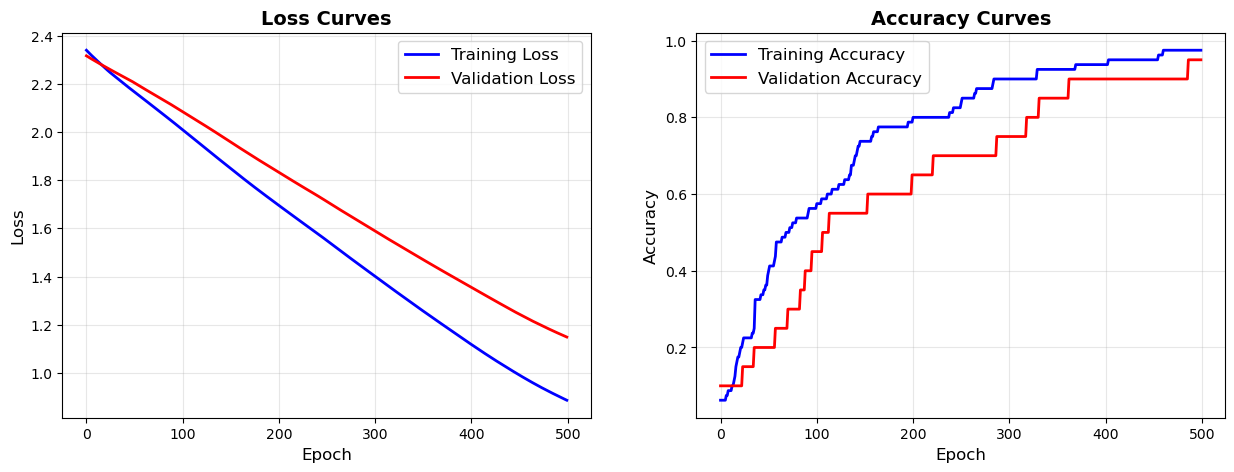

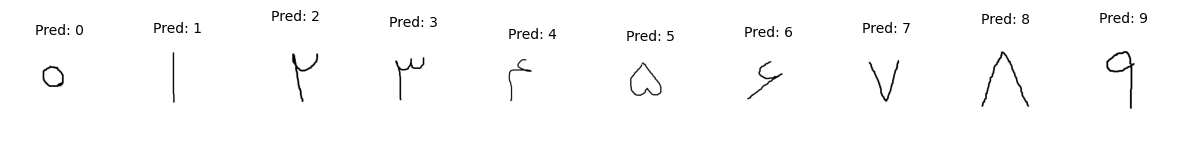

In [16]:
# === MAIN EXECUTION ===

print("\n Loading dataset...")
X, y_onehot, y_labels = load_dataset("data")
print(f"   Total samples: {X.shape[0]}")
print(f"   Feature dimension: {X.shape[1]}")
print(f"   Class distribution: {np.bincount(y_labels)}")

# Train/val split
X_train, X_val, y_train, y_val = train_test_split(
    X, y_onehot, test_size=0.2, random_state=42, stratify=y_labels
)
print(f"\n Training set: {X_train.shape[0]} samples | Validation set: {X_val.shape[0]} samples")

# Initialize model
model = SimpleNeuralNet(
    input_size=784,
    hidden_sizes=[64, 32],
    output_size=10,
    init_method='xavier'
)

# Train model
print("\n Training model...")
start_time = time.time()
history = model.train(
    X_train, y_train,
    epochs=500,
    lr=0.01,
    label_smoothing=0.1,
    X_val=X_val,
    y_val=y_val,
    verbose=True
)

# Analyze overfitting
performance_gap = analyze_overfitting(model, X_train, y_train, X_val, y_val)

# Plot learning curves
plot_overfitting_analysis(history)

# Test on external samples
sample_accuracy = test_model_on_samples(model, "test_input")
